# Explicabilidad y Diagnóstico

In [76]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import shap

In [77]:
# Cargar dataset
df = pd.read_csv('../data/processed/modeling_dataset.csv')
df['fecha_primera_sesion'] = pd.to_datetime(df['fecha_primera_sesion'])

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   uid                                   36523 non-null  uint64        
 1   n_compras                             36523 non-null  int64         
 2   revenue_total                         36523 non-null  float64       
 3   aov                                   36523 non-null  float64       
 4   fecha_primera_compra                  36523 non-null  object        
 5   fecha_ultima_compra                   36523 non-null  object        
 6   dias_entre_compras                    36523 non-null  int64         
 7   is_retained                           36523 non-null  int64         
 8   meses_activo                          36523 non-null  float64       
 9   gasto_mensual_promedio                36523 non-null  float64       
 10

In [79]:
df.head()

,uid,n_compras,revenue_total,aov,fecha_primera_compra,fecha_ultima_compra,dias_entre_compras,is_retained,meses_activo,gasto_mensual_promedio,...,n_sesiones,CAC_source_30,cohort_year,cohort_month,duracion_promedio_sesion,n_dispositivos_distintos,dias_activo,LTV_180,trend_slope,has_slope
0,313578113262317,1,0.55,0.550,2018-01-03 21:51:00,2018-01-03 21:51:00,0,0,1.0,0.55,...,3,0.340746,2017,9,660.0,1,173,0.55,NaN,0
1,1575281904278712,2,3.05,1.525,2017-06-03 10:13:00,2017-06-03 17:39:00,0,0,1.0,3.05,...,2,0.184264,2017,6,480.0,1,0,3.05,NaN,0
2,2429014661409475,1,73.33,73.330,2017-10-11 18:33:00,2017-10-11 18:33:00,0,0,1.0,73.33,...,1,0.571038,2017,10,780.0,1,0,73.33,NaN,0
3,2464366381792757,1,2.44,2.440,2018-01-28 15:54:00,2018-01-28 15:54:00,0,0,1.0,2.44,...,2,0.264780,2018,1,450.0,1,0,2.44,NaN,0
4,2551852515556206,2,10.99,5.495,2017-11-24 10:14:00,2017-11-24 11:24:00,0,0,1.0,10.99,...,2,0.264780,2017,11,279.5,1,0,10.99,NaN,0


In [80]:
# Eliminar filas con nulos en la columna target
df = df.dropna(subset=['LTV_180'])

In [81]:
columnas_excluir = [
    'LTV_180',
    'fecha_primera_sesion',
    'uid',
    'fecha_primera_compra',
    'fecha_ultima_compra'
]

In [82]:
def dividir_dataset(df, fecha_col='fecha_primera_sesion'):
    fecha_val_inicio = pd.Timestamp('2018-01-01')
    fecha_val_fin = pd.Timestamp('2018-06-30')
    fecha_test_inicio = pd.Timestamp('2018-07-01')
    fecha_test_fin = pd.Timestamp('2018-12-31')

    df_train = df[df[fecha_col] < fecha_val_inicio]
    df_val = df[(df[fecha_col] >= fecha_val_inicio) & (df[fecha_col] <= fecha_val_fin)]
    df_test = df[(df[fecha_col] >= fecha_test_inicio) & (df[fecha_col] <= fecha_test_fin)]

    return df_train, df_val, df_test

In [83]:
train, val, test = dividir_dataset(df)

X_val = val.drop(columns=columnas_excluir)
y_val = val['LTV_180']

## LTV_180

### Importancia de variables

`Modelo: Xgboost`

In [84]:
with open('../models/LTV_180/xgb.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

/Users/titusr09/Downloads/DataMiningProyectoFinal/venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/1p/fq1m75_x51v5l3dmf0wxswbr0000gn/T/ipykernel_3094/2316105728.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal at

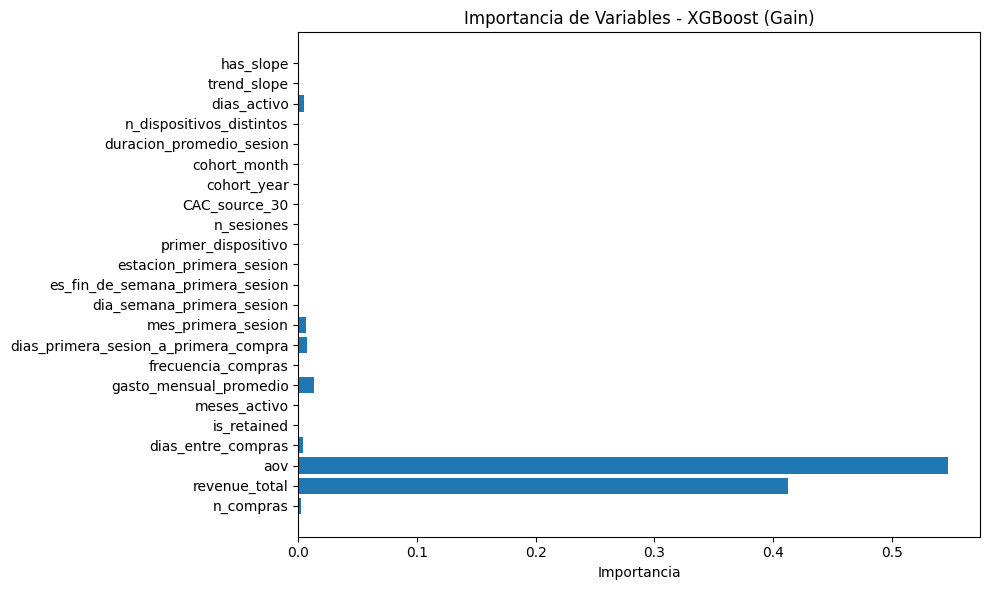

In [85]:
# Extraer importancias del modelo
importancias = xgb_model.named_steps['modelo'].feature_importances_
features = xgb_model.named_steps['pre'].transformers_[0][2]  # columnas del paso 'scale'

plt.figure(figsize=(10, 6))
plt.barh(features, importancias)
plt.title('Importancia de Variables - XGBoost (Gain)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

### PDP — Partial Dependence Plot

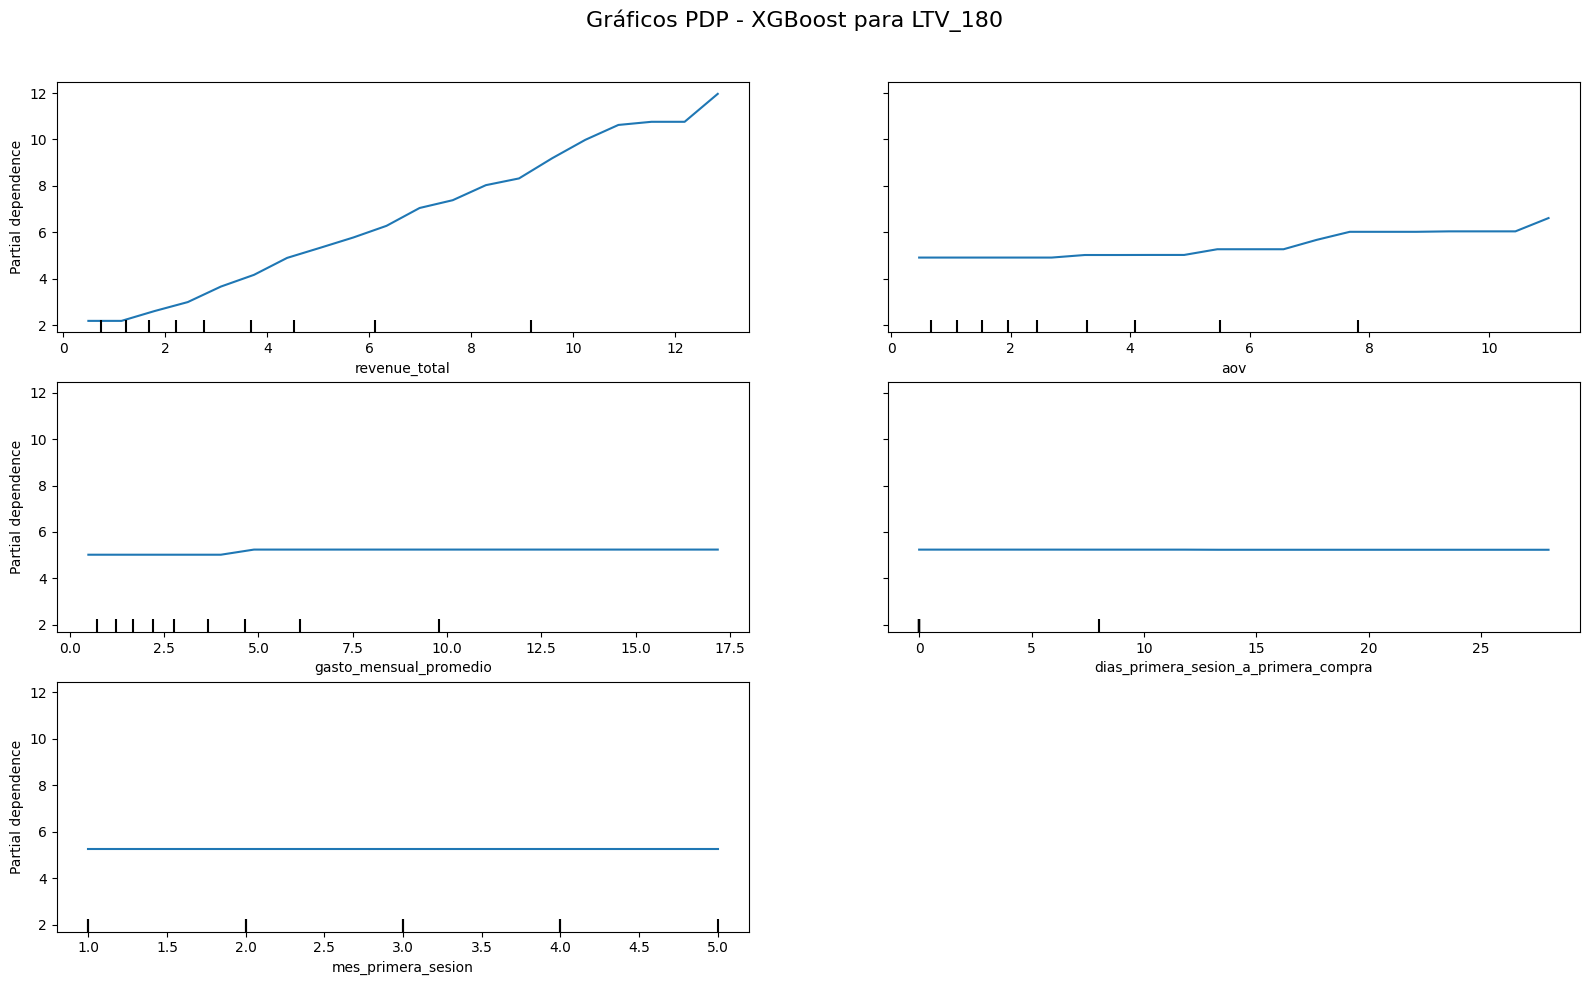

In [86]:
from sklearn.inspection import PartialDependenceDisplay

features_pdp = ['revenue_total', 'aov', 'gasto_mensual_promedio', 'dias_primera_sesion_a_primera_compra', 'mes_primera_sesion']

# Ajustamos el número de columnas (n_cols) y tamaño general del gráfico
fig, ax = plt.subplots(figsize=(16, 10))  # más espacio y más ancho

display = PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_val,
    features=features_pdp,
    feature_names=X_val.columns,
    grid_resolution=20,
    ax=ax,
    n_cols=2  # Distribuye en 2 columnas
)

plt.suptitle('Gráficos PDP - XGBoost para LTV_180', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # espacio para el título
plt.show()

### Análisis de errores sistemáticos — ¿Dónde falla el modelo?

In [87]:
# Predecir
y_pred = xgb_model.predict(X_val)

# Calcular error absoluto
error_abs = np.abs(y_val - y_pred)

# Unir al DataFrame de validación
df_errores = X_val.copy()
df_errores['y_true'] = y_val
df_errores['y_pred'] = y_pred
df_errores['error_abs'] = error_abs

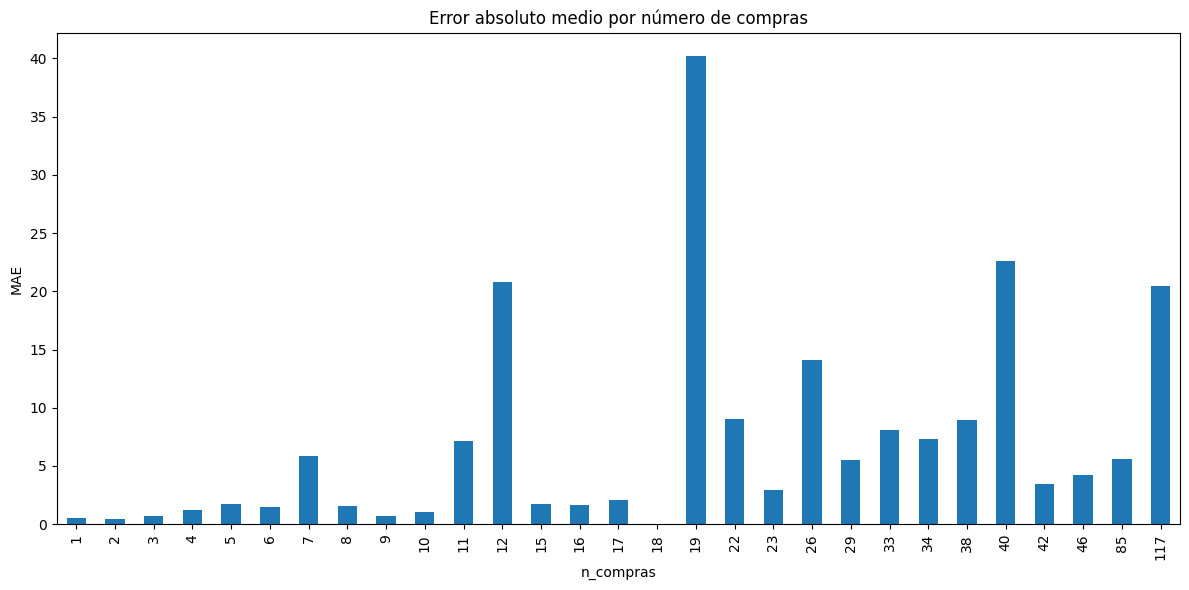

In [88]:
df_errores.groupby('n_compras')['error_abs'].mean().sort_index().plot(kind='bar', figsize=(12,6))
plt.title('Error absoluto medio por número de compras')
plt.xlabel('n_compras')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

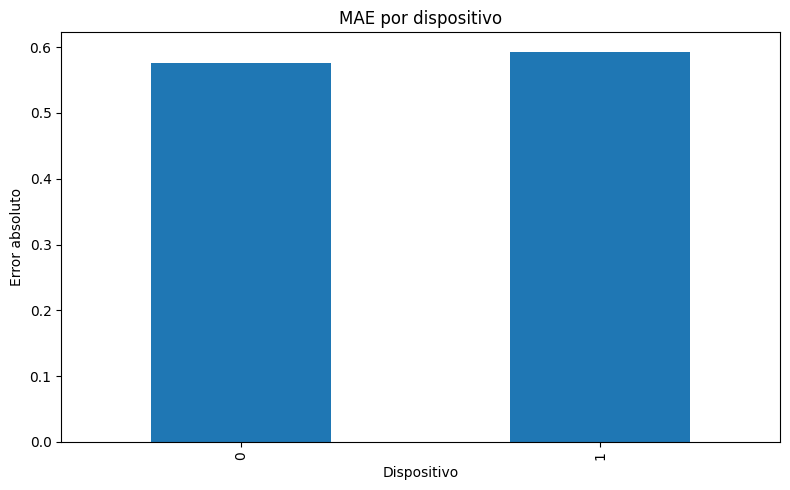

In [89]:
df_errores.groupby('primer_dispositivo')['error_abs'].mean().plot(kind='bar', figsize=(8,5))
plt.title('MAE por dispositivo')
plt.ylabel('Error absoluto')
plt.xlabel('Dispositivo')
plt.tight_layout()
plt.show()

/var/folders/1p/fq1m75_x51v5l3dmf0wxswbr0000gn/T/ipykernel_3094/1317714593.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_errores.groupby('segmento_revenue')['error_abs'].mean().plot(kind='barh', figsize=(10, 6))


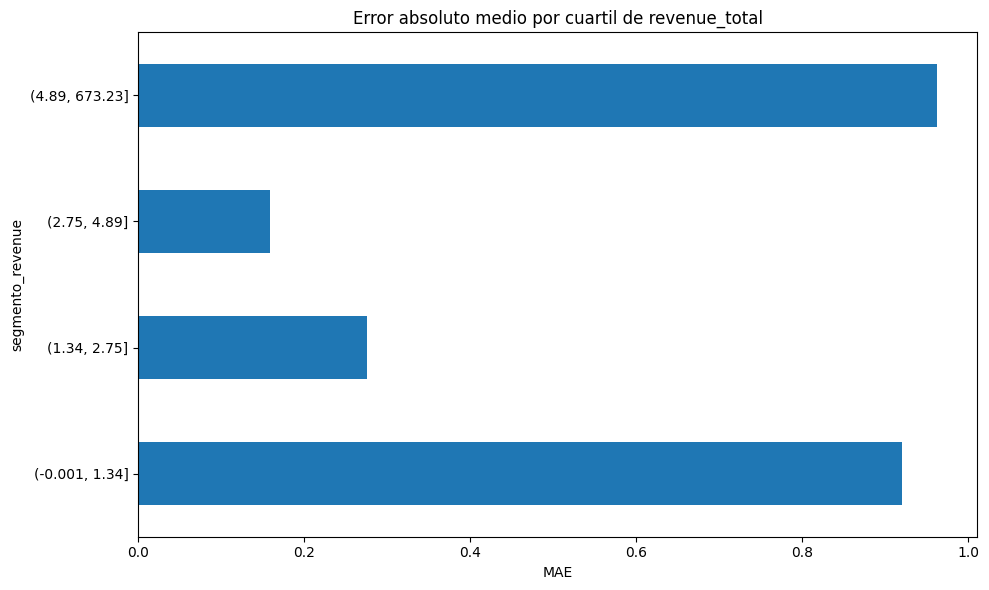

In [90]:
df_errores['segmento_revenue'] = pd.qcut(df_errores['revenue_total'], 4, duplicates='drop')

df_errores.groupby('segmento_revenue')['error_abs'].mean().plot(kind='barh', figsize=(10, 6))
plt.title('Error absoluto medio por cuartil de revenue_total')
plt.xlabel('MAE')
plt.tight_layout()
plt.show()

In [91]:
df_errores.sort_values('error_abs', ascending=False).head(10)

,n_compras,revenue_total,aov,dias_entre_compras,is_retained,meses_activo,gasto_mensual_promedio,frecuencia_compras,dias_primera_sesion_a_primera_compra,mes_primera_sesion,...,cohort_month,duracion_promedio_sesion,n_dispositivos_distintos,dias_activo,trend_slope,has_slope,y_true,y_pred,error_abs,segmento_revenue
26753,19,673.23,35.433158,49,1,1.633333,412.181633,2.578947,4,4,...,4,2044.363636,1,53,0.357543,1,673.23,595.681213,77.548787,"(4.89, 673.23]"
5701,12,398.43,33.202500,20,0,0.666667,597.645000,1.666667,0,1,...,1,935.625000,1,26,0.819499,1,398.43,358.711487,39.718513,"(4.89, 673.23]"
25048,11,388.98,35.361818,80,1,2.666667,145.867500,7.272727,0,3,...,3,3253.333333,1,80,-0.478029,1,388.98,357.367493,31.612507,"(4.89, 673.23]"
12863,40,162.39,4.059750,119,1,3.966667,40.938655,2.975000,0,1,...,1,1738.125000,1,122,0.005270,1,162.39,139.797775,22.592225,"(4.89, 673.23]"
12332,117,507.32,4.336068,64,1,2.133333,237.806250,0.547009,0,3,...,3,908.899522,1,64,0.018038,1,507.32,527.734314,20.414314,"(4.89, 673.23]"
18277,3,196.16,65.386667,6,0,0.200000,980.800000,2.000000,51,2,...,2,1268.571429,1,57,-13.596667,1,196.16,181.317352,14.842648,"(4.89, 673.23]"
11955,26,90.69,3.488077,84,1,2.800000,32.389286,3.230769,0,3,...,3,1000.000000,1,84,0.023144,1,90.69,76.548325,14.141675,"(4.89, 673.23]"
4227,22,124.86,5.675455,44,1,1.466667,85.131818,2.000000,0,4,...,4,576.666667,2,43,-0.123934,1,124.86,111.613983,13.246017,"(4.89, 673.23]"
3411,1,122.22,122.220000,0,0,1.000000,122.220000,0.000000,126,1,...,1,277.500000,2,127,NaN,0,122.22,109.097084,13.122916,"(4.89, 673.23]"
21488,34,150.60,4.429412,97,1,3.233333,46.577320,2.852941,0,2,...,2,854.181818,1,98,0.032854,1,150.60,139.290909,11.309091,"(4.89, 673.23]"


## CAC_source_30

`Modelo: Ridge`

In [92]:
df_cac = pd.read_csv('../data/processed/modeling_dataset.csv', parse_dates=['fecha_primera_sesion'])

In [93]:
# Filtrar filas con datos completos para CAC
df_cac = df.dropna(subset=['CAC_source_30'])

In [94]:
# Excluir columnas no utilizadas
columnas_excluir = [
    'CAC_source_30',
    'fecha_primera_sesion',
    'uid',
    'fecha_primera_compra',
    'fecha_ultima_compra'
]


In [95]:
# Dividir el dataset
train, val, test = dividir_dataset(df_cac)

X_val_cac = val.drop(columns=columnas_excluir)
y_val_cac = val['CAC_source_30']

### Importancia de variables

In [96]:
with open('../models/CAC_source_30/ridge.pkl', 'rb') as f:
    ridge_model = pickle.load(f)

/Users/titusr09/Downloads/DataMiningProyectoFinal/venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/1p/fq1m75_x51v5l3dmf0wxswbr0000gn/T/ipykernel_3094/1655504135.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal at

In [97]:
# Separar el modelo y el preprocesador
ridge_regressor = ridge_model.named_steps['modelo']
input_features = ridge_model.named_steps['pre'].transformers_[0][2]

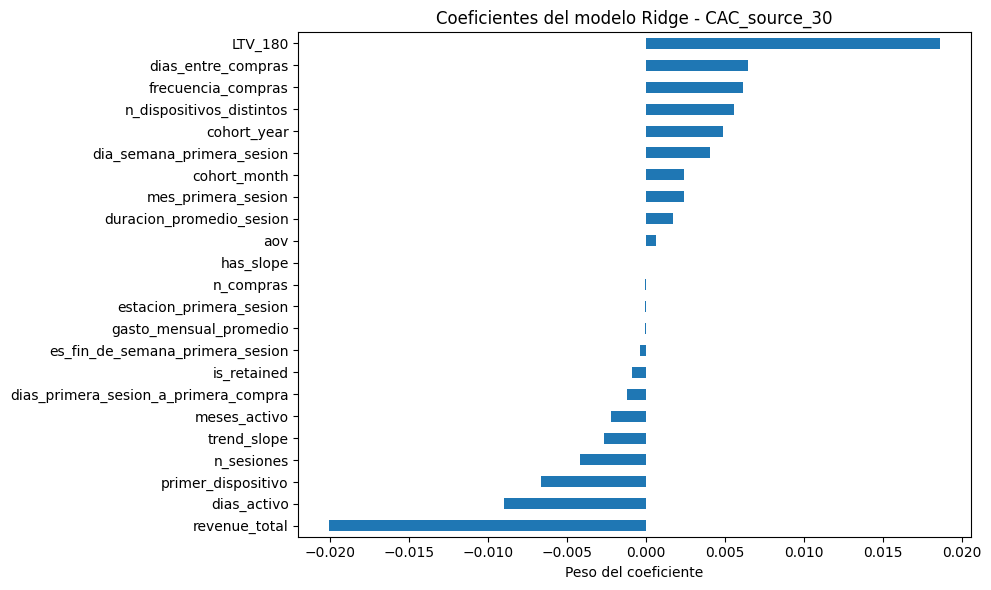

In [98]:
coef = ridge_regressor.coef_

# Mostrar coeficientes ordenados
pd.Series(coef, index=input_features).sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Coeficientes del modelo Ridge - CAC_source_30')
plt.xlabel('Peso del coeficiente')
plt.tight_layout()
plt.show()

### PDP (Partial Dependence Plot)

In [ ]:
X_val_cac = X_val_cac.dropna()
y_val_cac = y_val_cac.loc[X_val_cac.index]

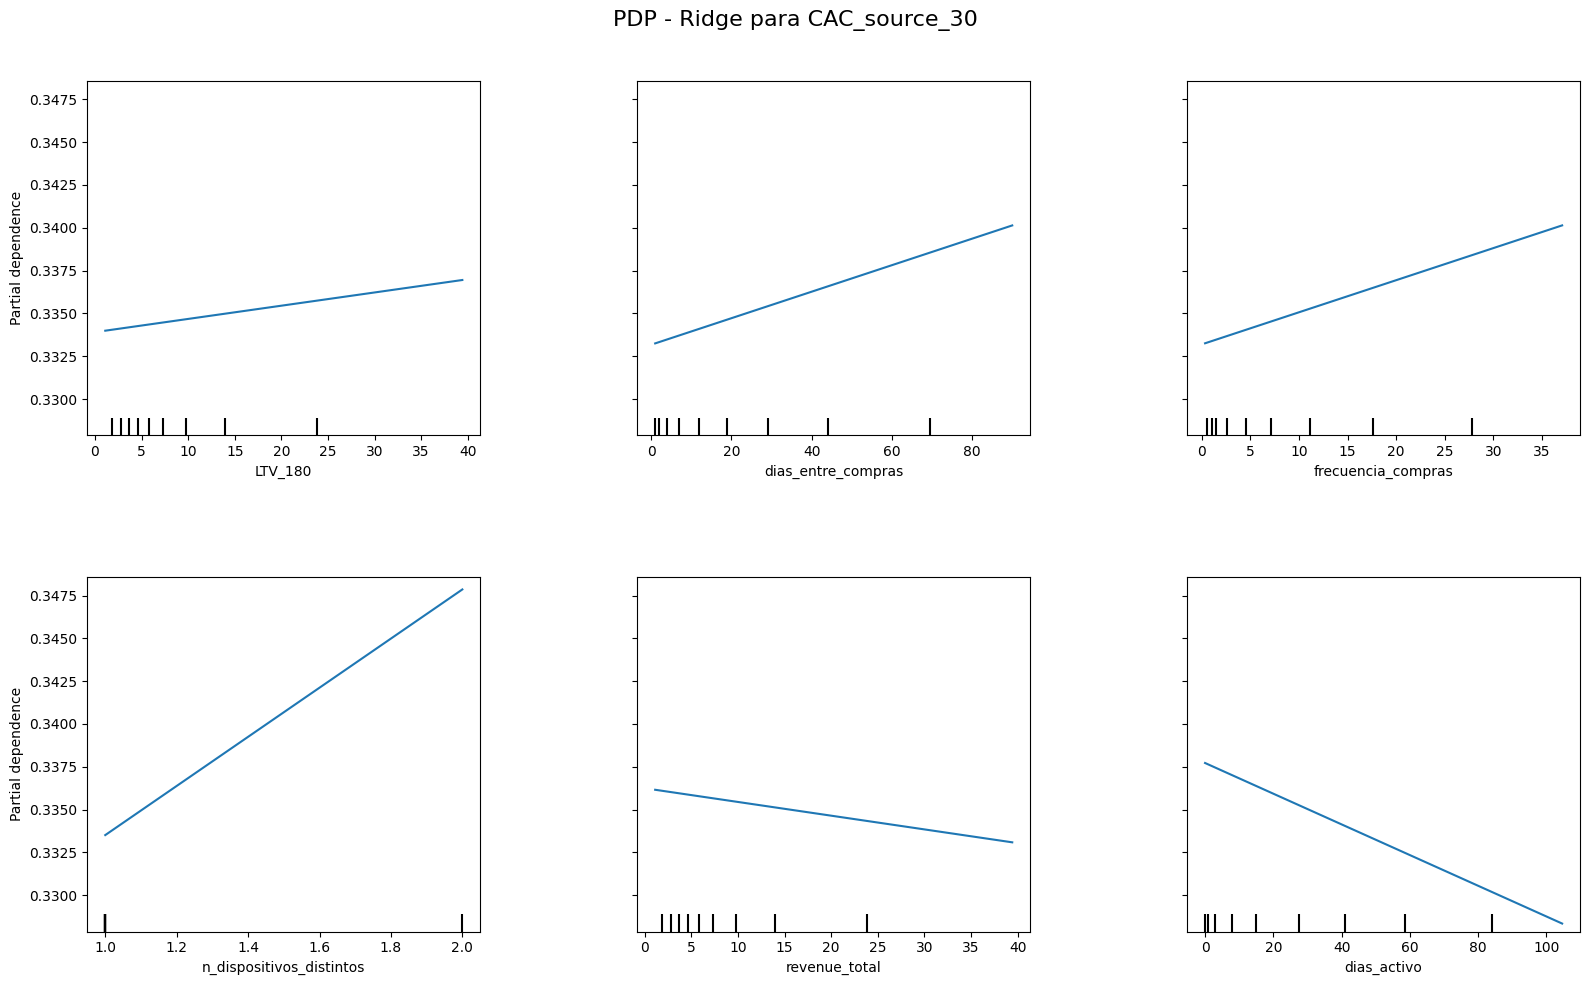

In [120]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Features para PDP (de acuerdo a lo que has seleccionado)
features_pdp_cac = ['LTV_180', 'dias_entre_compras', 'frecuencia_compras', 'n_dispositivos_distintos', 'revenue_total', 'dias_activo']

# Generar el gráfico PDP para Ridge
fig, ax = plt.subplots(figsize=(16, 10))

# Mostrar PDP para las features seleccionadas
PartialDependenceDisplay.from_estimator(
    ridge_model,
    X_val_cac,
    features=features_pdp_cac,
    feature_names=X_val_cac.columns,
    grid_resolution=50,
    ax=ax,
    n_cols=3, 
    kind='average'
)

# Añadir título y ajustar el diseño de los gráficos
plt.suptitle('PDP - Ridge para CAC_source_30', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.4) 
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Análisis de errores sistemáticos — ¿Dónde falla el modelo?

In [122]:
# Calcular los errores
y_pred = ridge_model.predict(X_val_cac)
errores = y_pred - y_val_cac

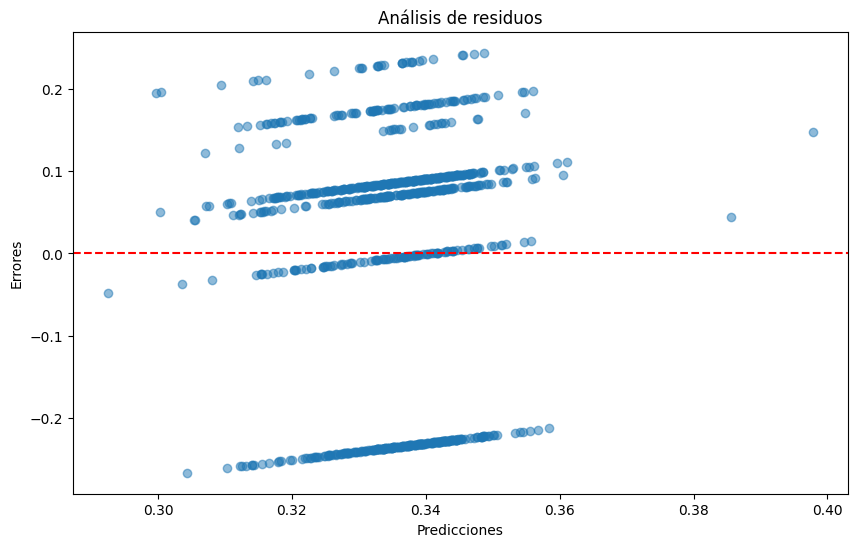

In [123]:
# Gráfico de residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, errores, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Errores')
plt.title('Análisis de residuos')
plt.show()

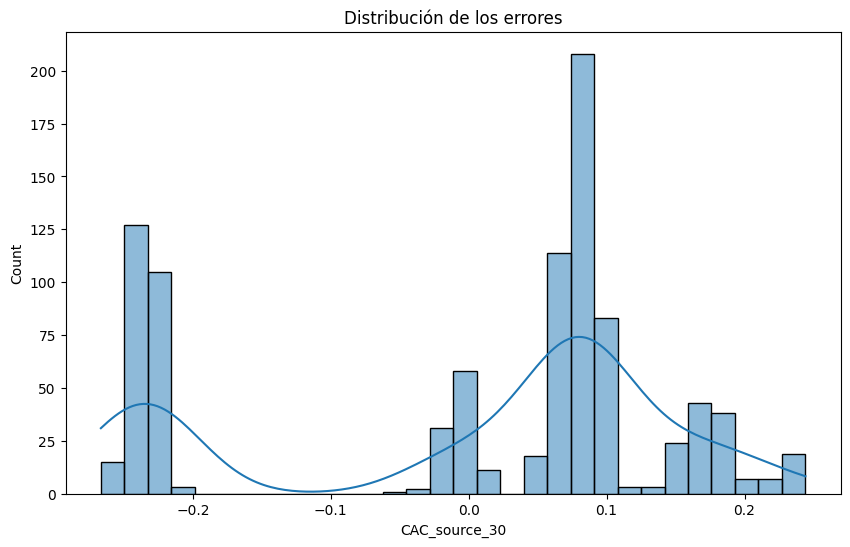

In [126]:
import seaborn as sns

# Histograma de los errores
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=30, kde=True)
plt.title('Distribución de los errores')
plt.show()